# [Sutton and Barto Notebooks](https://github.com/seungjaeryanlee/sutton-barto-notebooks): Figure 6.5 v2 DRAFT

Author: Ryan Lee  
저자: 이승재  

## Revisions
 * Simple UI has been added to visualize updates on Q values.
 * Number of actions in B can now be specified when creating Environment.
 * epsilon, learning_rate, discount_factor can now be specified when creating Agent.

To look at other versions, visit [GitHub](https://github.com/seungjaeryanlee/sutton-barto-notebooks).

## 바뀐 점들
 * Q값과 policy를 보여주는 간단한 UI를 만들었습니다.
 * 환경을 만들 때 B에서 가능한 행동의 수를 설정할 수 있습니다.
 * 에이전트를 만들 때 엡실론, 학습률, 감가율을 설정할 수 있습니다.
 
예전 버전들은 [깃허브](https://github.com/seungjaeryanlee/sutton-barto-notebooks)에 저장되어 있습니다.

This notebook is an implementation of Figure 6.5 in [Sutton and Barto's Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html).  
이 노트북은 [Sutton and Barto의 Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book-2nd.html) 책의 Figure 6.5를 구현한 결과입니다.

![Figure 6.5](figure.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def argmax_all(list_):
    """
    Returns all argmax of given list in a list. Different from np.argmax which returns first instance only.
    주어진 list의 최대값들의 index들을 list 형태로 반환합니다. 첫 최대값의 index만 반환하는 np.argmax와는 다릅니다.
    """
    return np.argwhere(list_ == np.max(list_)).flatten().tolist()

In [3]:
from enum import IntEnum
class Action(IntEnum):
    """
    Actions possible in state A.
    상태 A에서 선택 가능한 행동들.
    """
    LEFT = 0
    RIGHT = 1

In [4]:
class Environment:
    """
    Simple two-armed bandit environment shown in Sutton and Barto Figure 6.5.
    Sutton and Barto Figure 6.5의 환경입니다.
    """
    def __init__(self, n_actions=10):
        self.state = 'A'
        self.NUMBER_OF_ACTIONS = n_actions # Number of actions possible in state B

    def action_space(self):
        """
        Return all possible actions for the current state.
        현재 상태에서의 가능한 모든 행동을 반환합니다.
        """
        if self.state == 'A':
            return [Action.LEFT, Action.RIGHT]
        elif self.state == 'B':
            return range(self.NUMBER_OF_ACTIONS)
        else:
            return []

    def is_terminal(self):
        """
        Check is the current state is terminal.
        현재 상태가 끝 상태인지 확인합니다.
        """
        return self.state == 'X'

    def reset(self):
        """
        Reset environment and return initial state.
        환경을 초기화하고 첫 상태를 반환합니다.
        """
        self.state = 'A'
        return self.state

    def step(self, action):
        """
        Take a given action and return tuple (next_state, reward, done).
        주어진 행동을 취하고 (다음 상태, 보상, 에피소드가 끝남)를 반환합니다.
        """
        if self.state == 'A' and action == Action.LEFT:
            self.state = 'B'
            return ('B', 0, False)
        elif self.state == 'A' and action == Action.RIGHT:
            self.state = 'X'
            return ('X', 0, True)
        else:
            self.state = 'X'
            return ('X', np.random.normal(-0.1, 1), True)

In [5]:
class QLearningAgent:
    def __init__(self, env, epsilon=0.1, learning_rate=0.1, discount_factor=1):
        """
        Initialize Q table and save environment.
        Q 테이블을 초기화하고 주어진 환경을 보관합니다.
        """
        self.q_table = {
            'A': [0, 0],
            'B': [0] * env.NUMBER_OF_ACTIONS
        }
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        엡실론 탐욕 정책과 Q테이블을 이용해 주어진 상태에서 할 행동을 반환합니다.
        """
        best_actions = argmax_all(self.q_table[state])

        if np.random.choice(['e', '1-e'], p=[self.epsilon, 1 - self.epsilon]) == 'e':
            return np.random.choice(self.env.action_space())
        else:
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via Q-learning.
        Q러닝을 통해 Q 테이블을 업데이트합니다.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])

        self.q_table[state][action] = ((1 - self.learning_rate) * self.q_table[state][action] 
                                    + self.learning_rate * target)
    
    def reset(self):
        """
        Reset the Q table.
        Q테이블을 초기화합니다.
        """
        self.q_table = {
            'A': [0, 0],
            'B': [0] * self.env.NUMBER_OF_ACTIONS
        }

In [6]:
class DoubleQLearningAgent:
    def __init__(self, env, epsilon=0.1, learning_rate=0.1, discount_factor=1):
        """
        Initialize Q table and save environment.
        Q 테이블을 초기화하고 주어진 환경을 보관합니다.
        """
        self.q1 = {'A': [0, 0], 'B': [0] * env.NUMBER_OF_ACTIONS}
        self.q2 = {'A': [0, 0], 'B': [0] * env.NUMBER_OF_ACTIONS}
        self.q_table = [self.q1, self.q2]
        self.env = env
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def get_action(self, state):
        """
        Returns action based on Q table and epsilon-greedy policy.
        엡실론 탐욕 정책과 Q테이블을 이용해 주어진 상태에서 할 행동을 반환합니다.
        """
        q_state = np.add(self.q1[state], self.q2[state])
        best_actions = argmax_all(q_state)

        if np.random.choice(['e', '1-e'], p=[self.epsilon, 1 - self.epsilon]) == 'e':
            return np.random.choice(self.env.action_space())
        else:
            return np.random.choice(best_actions)

    def update_q(self, state, action, reward, next_state, done):
        """
        Update Q table via Double Q-learning.
        더블 Q러닝을 통해 Q 테이블을 업데이트합니다.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * self.q2[next_state][np.argmax(self.q1[next_state])]
        
        if np.random.choice(['q1', 'q2']) == 'q1':
            self.q1[state][action] = ((1 - self.learning_rate) * self.q1[state][action]
                                   + self.learning_rate * target)
        else:
            self.q2[state][action] = ((1 - self.learning_rate) * self.q2[state][action]
                                   + self.learning_rate * target)

    def reset(self):
        """
        Reset the Q table.
        Q테이블을 초기화합니다.
        """
        self.q1 = {'A': [0, 0], 'B': [0] * self.env.NUMBER_OF_ACTIONS}
        self.q2 = {'A': [0, 0], 'B': [0] * self.env.NUMBER_OF_ACTIONS}
        self.q_table = [self.q1, self.q2]

In [7]:
def run_episode(agent, env):
    """
    Runs one episode of environment with agent. (Only for debugging)
    주어진 Agent 클래스로 에이전트를 만들어서 에피소드를 1번 실행합니다. (디버깅 전용)
    """
    state = env.reset()
    
    done = False
    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        print('State      : ', state)
        print('Action     : ', action)
        print('Reward     : ', reward)
        print('Next State : ', next_state)

        agent.update_q(state, action, reward, next_state, done)
        print(agent.q_table)
        
        state = next_state

In [8]:
env = Environment()
agent = QLearningAgent(env)
run_episode(agent, env)

State      :  A
Action     :  1
Reward     :  0
Next State :  X
{'A': [0, 0.0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [9]:
env = Environment()
agent = DoubleQLearningAgent(env)
run_episode(agent, env)

State      :  A
Action     :  0
Reward     :  0
Next State :  B
[{'A': [0.0, 0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'A': [0, 0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]
State      :  B
Action     :  8
Reward     :  -1.2656425436069312
Next State :  X
[{'A': [0.0, 0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'A': [0, 0], 'B': [0, 0, 0, 0, 0, 0, 0, 0, -0.12656425436069313, 0]}]


In [10]:
def run_trials(n_trials, n_episodes, agent, env):
    """
    Runs `n_trials` trials on given environment and agent. For each trial,
    `n_episodes` episodes are run, and Q table is reset after each trial.
    주어진 Agent와 Environment로 활용해서 트라이얼을 n_trial번 실행합니다. 각
    트라이얼마다 에피소드를 n_episode번 실행하며, 매 트라이얼마다 Q 테이블을 초기화합니다.
    """
    left_selected_per_episode = [0] * n_episodes

    for _ in range(n_trials):
        agent.reset()
        for episode_i in range(n_episodes):
            state = env.reset()
            
            done = False
            while not done:
                action = agent.get_action(state)
                next_state, reward, done = env.step(action)
                agent.update_q(state, action, reward, next_state, done)

                if state == 'A' and action == Action.LEFT:
                    left_selected_per_episode[episode_i] += 1

                state = next_state

    # Calculate Percentage
    left_select_percentages = np.divide(left_selected_per_episode, n_trials)
    left_select_percentages[0] = 0.5
    return left_select_percentages

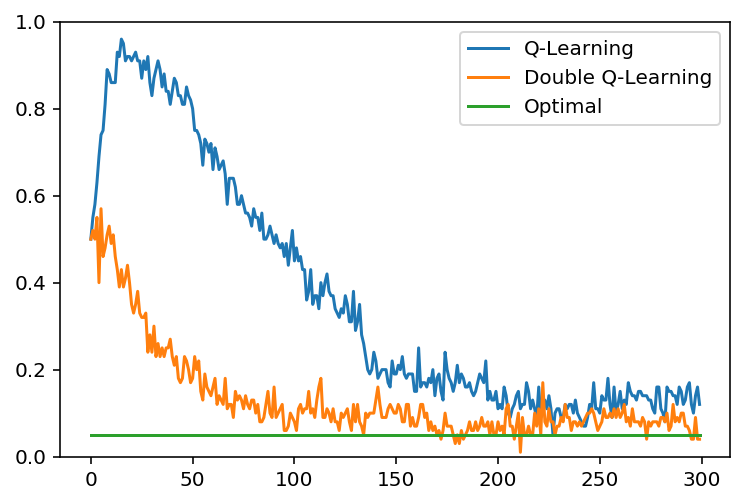

In [11]:
NUM_TRIALS = 100   #트라이얼 횟수: 오래 걸리니 100, 1000정도 추천
NUM_EPISODES = 300 #트라이얼마다 행하는 에피소드 횟수

env1 = Environment()
agent1 = QLearningAgent(env1)
p1 = run_trials(NUM_TRIALS, NUM_EPISODES, agent1, env1)

env2 = Environment()
agent2 = DoubleQLearningAgent(env2)
p2 = run_trials(NUM_TRIALS, NUM_EPISODES, agent2, env2)

plt.ylim(0, 1)
plt.plot(range(NUM_EPISODES), p1)
plt.plot(range(NUM_EPISODES), p2)
plt.plot(range(NUM_EPISODES), [agent1.epsilon / 2] * NUM_EPISODES)
plt.legend(['Q-Learning', 'Double Q-Learning', 'Optimal'])
# plt.savefig('result.png')
plt.show()

## Additional Materials (추가 자료)

This is not part of Sutton & Barto, but it might help you understand why Q Learning algorithm tends to overestimate.  
이것은 책에 포함되어 있지 않은 내용이자만, Q러닝이 왜 과도하게 Q값을 높게 설정하게 되는지 이해할 때 도움이 될 수 있습니다.

### Q Value Plot

This is a plot of Q values for the 'left' action in state A.  
이것은 A에서 왼쪽 행동의 Q값을 그린 그래프입니다.

In [38]:
def plot_q_values(agent, env, n_episodes=300):
    q_values = []
    if isinstance(agent, DoubleQLearningAgent):
        q1_values = []
        q2_values = []

    for _ in range(n_episodes):
        state = env.reset()

        done = False
        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update_q(state, action, reward, next_state, done)
            state = next_state

        if isinstance(agent, QLearningAgent):
            q_values.append(agent.q_table['A'][Action.LEFT])
        elif isinstance(agent, DoubleQLearningAgent):
            q1_values.append(agent.q1['A'][Action.LEFT])
            q2_values.append(agent.q2['A'][Action.LEFT])
            q_values.append(agent.q1['A'][Action.LEFT] + agent.q2['A'][Action.LEFT])
        else:
            raise ValueError('Agent should be an instance of QLearningAgent or DoubleQLearningAgent.')

    plt.ylim(-0.5, 0.5)
    if isinstance(agent, QLearningAgent):
        plt.plot(range(n_episodes), q_values)
        plt.legend(['Q'])
    else:
        plt.plot(range(n_episodes), q1_values)
        plt.plot(range(n_episodes), q2_values)
        plt.plot(range(n_episodes), q_values)
        plt.legend(['Q1', 'Q2', 'Q1+Q2'])
    plt.show()

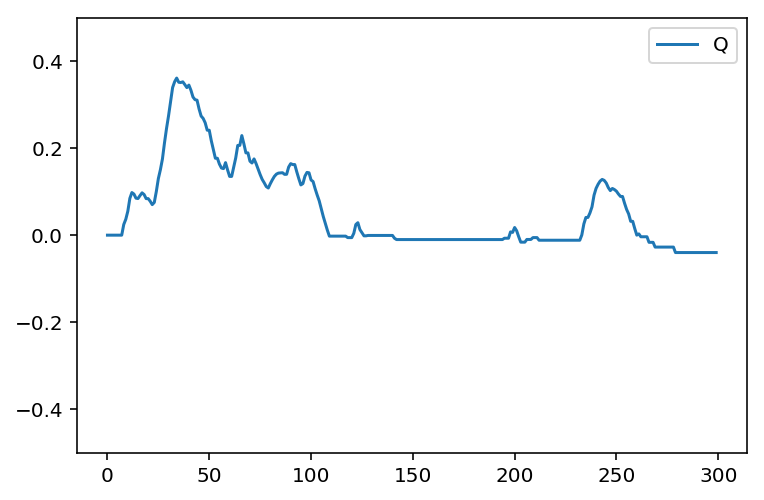

In [47]:
env = Environment()
agent = QLearningAgent(env)
plot_q_values(agent, env)

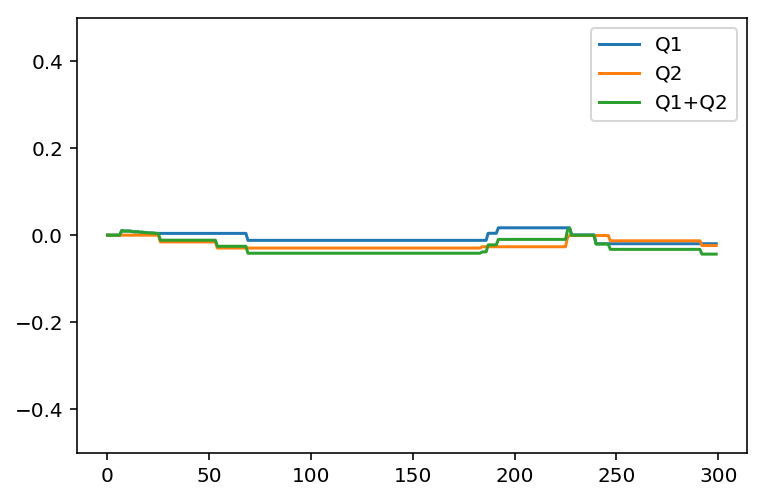

In [64]:
env = Environment()
agent = DoubleQLearningAgent(env)
plot_q_values(agent, env)

### GUI

In [14]:
import tkinter as tk
import copy

In [65]:
class GUI(tk.Tk):
    """
    GUI for Figure 6.5
    Figure 6.5를 위한 GUI
    """
    def __init__(self, agent, env):
        self.episode_count = 0
        self.last_reward = 0
        self.agent = agent
        self.env = env
        self.state = env.reset()

        tk.Tk.__init__(self)
        self.canvas = self._build_canvas()
        self._update_canvas()
        
        # (state, Q table, reward, episode_count)
        self.cache = []

    def _build_canvas(self):
        """
        Builds a tkinter canvas.
        tkinter 캔버스를 세팅합니다.
        """
        canvas_w, canvas_h = (600, 400) # Canvas Dimensions

        t1_x, t1_y = (150, 100)         # Position of terminal state 1
        b_x, b_y   = (250, 100)         # Position of state B
        a_x, a_y   = (350, 100)         # Position of state A
        t2_x, t2_y = (450, 100)         # Position of terminal state 2

        r = 20                          # Radius of nodes (states)

        canvas = tk.Canvas(self, width=canvas_w, height=canvas_h, bg='white')

        # Nodes
        self.node_b = canvas.create_oval(b_x-r, b_y-r, b_x+r, b_y+r)
        self.node_a = canvas.create_oval(a_x-r, a_y-r, a_x+r, a_y+r)
        canvas.create_rectangle(t1_x-r, t1_y-r, t1_x+r, t1_y+r, fill='#eee')
        canvas.create_rectangle(t2_x-r, t2_y-r, t2_x+r, t2_y+r, fill='#eee')
        canvas.create_text(a_x, a_y, text='A')
        canvas.create_text(b_x, b_y, text='B')

        # Arrows (except B -> T1)
        canvas.create_line(b_x-r,b_y, t1_x+r, t1_y, arrow="last")
        self.arrow_left = canvas.create_line(a_x-r,a_y, b_x+r, b_y, arrow="last")
        self.arrow_right = canvas.create_line(a_x+r,a_y, t2_x-r, t2_y, arrow="last")

        # Info Text
        self.text_episode_count = canvas.create_text(canvas_w/2, 20)
        self.text_reward = canvas.create_text(canvas_w/2, 40)
        self.text_target = canvas.create_text(canvas_w/2, 60)

        # Q Table
        self.text_left = canvas.create_text((b_x+a_x)/2, a_y+10)
        self.text_right = canvas.create_text((a_x+t2_x)/2, a_y+10)
        self.text_q_values_in_b = []
        self.arrows = []
        for i in range(env.NUMBER_OF_ACTIONS):
            self.arrows.append(canvas.create_line(b_x-r,b_y+r*i, t1_x+r, t1_y+r*i, arrow="last"))
            self.text_q_values_in_b.append(canvas.create_text((t1_x+b_x)/2, t1_y+r*i+10))

        # Back Button
        back_button = tk.Button(self, text="Back", command=self.back_step, width=40, height=3)
        canvas.create_window(canvas_w/4, canvas_h-25, window=back_button)

        # Step Button
        step_button = tk.Button(self, text="Step", command=self.run_step, width=40, height=3)
        canvas.create_window(3*canvas_w/4, canvas_h-25, window=step_button)

        canvas.pack(side="top", fill="both", expand=True)

        return canvas

    def run_step(self):
        """
        Take one step in the environment with the agent and update canvas.
        한 번 행동을 취하고 캔버스를 업데이트합니다.
        """
        self.cache.append((self.state, copy.deepcopy(self.agent.q_table), self.last_reward, self.episode_count))

        action = self.agent.get_action(self.state)
        next_state, self.last_reward, done = self.env.step(action)
        self.agent.update_q(self.state, action, self.last_reward, next_state, done)
        self.state = next_state

        if done:
            self.state = self.env.reset()
            self.episode_count += 1

        self._update_canvas()

    # HACK: Change to self-documenting code
    def back_step(self):
        """
        Take back one step in the environment, also reverting the agent's Q values and updating the canvas.
        """
        if len(self.cache) <= 0:
            return

        self.state, q_table, self.last_reward, self.episode_count = self.cache.pop()
        self.env.state = self.state
        self.agent.q_table = copy.deepcopy(q_table)

        self._update_canvas()
    def _update_canvas(self):
        """
        Updates the canvas with agent's current Q table.
        현재 에이전트의 Q값들로 캔버스를 업데이트합니다.
        """
        # Update Info
        self.canvas.itemconfig(self.text_episode_count, text='Episode Count: %d' % self.episode_count)
        self.canvas.itemconfig(self.text_reward, text='Last Step\'s Reward: %.3f' % self.last_reward)

        # Update Q values
        if isinstance(agent, QLearningAgent):
            q_table = self.agent.q_table
        else:
            q_table = np.add(self.agent.q1, self.agent.q2)

        self.canvas.itemconfig(self.text_left, text='%.3f' % self.agent.q_table['A'][Action.LEFT])
        self.canvas.itemconfig(self.text_right, text='%.3f' % self.agent.q_table['A'][Action.RIGHT])
        for i in range(env.NUMBER_OF_ACTIONS):
            self.canvas.itemconfig(self.text_q_values_in_b[i], text='%.3f' % self.agent.q_table['B'][i])

        # Reset colors
        self.canvas.itemconfig(self.node_a, fill='white')
        self.canvas.itemconfig(self.node_b, fill='white')
        self.canvas.itemconfig(self.arrow_left, fill='black')
        self.canvas.itemconfig(self.arrow_right, fill='black')
        for i in range(self.env.NUMBER_OF_ACTIONS):
            self.canvas.itemconfig(self.arrows[i], fill='black')

        # Color current state
        if self.state == 'A':
            self.canvas.itemconfig(self.node_a, fill='#6ee')
        else:
            self.canvas.itemconfig(self.node_b, fill='#6ee')

        # Color greedy action
        if self.state == 'A':
            if q_table['A'][Action.LEFT] == q_table['A'][Action.RIGHT]:
                self.canvas.itemconfig(self.arrow_left, fill='red')
                self.canvas.itemconfig(self.arrow_right, fill='red')
            elif q_table['A'][Action.LEFT] > q_table['A'][Action.RIGHT]:
                self.canvas.itemconfig(self.arrow_left, fill='red')
            else:
                self.canvas.itemconfig(self.arrow_right, fill='red')
        else:
            max_indices = argmax_all(q_table['B'])
            for i in range(self.env.NUMBER_OF_ACTIONS):
                if i in max_indices:
                    self.canvas.itemconfig(self.arrows[i], fill='red')

In [66]:
env = Environment()
agent = QLearningAgent(env)
gui = GUI(agent, env)
gui.mainloop()

In [ ]:
env = Environment()
agent = DoubleQLearningAgent(env)
gui = GUI(agent, env)
gui.mainloop()